**Contents of the Notebook**

1 Data loading and overview
1.1 belongs_to_collection
1.2 genres
1.3 Production companies
1.4 Production countries
1.5 Spoken languages
1.6 Keywords
1.7 Cast
1.8 Crew

2 Data exploration
2.1 Target
2.2 Budget
2.3 Homepage
2.4 Original language
2.5 Original title
2.6 Overview
2.7 Popularity
2.8 Release date
2.9 Runtime
2.10 Status
2.11 Tagline
2.12 Collections
2.13 Genres
2.14 Production companies
2.15 Production countries
2.16 Cast
2.17 Keywords
2.18 Crew

3 Modelling and feature generation
3.1 OOF features based on texts
3.2 Additional feature generation
3.3 Important features
3.4 External features
3.5 Blending
3.6 Stacking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
#cd /content/drive/MyDrive/
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [ ]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]


In [ ]:
!pip install eli5
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=234d98d2e0f35abf8b215f7f6b7e7562f9cc8711cadb31115d8b67e3c504795e
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
# pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import ast
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
# stop = set(stopwords.words('english'))
# import os
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [ ]:

#train dataset
train_file = 'box_office_train.csv'
train_df = pd.read_csv(train_file)

#test dataset
test_file = 'box_office_test.csv'
test_df = pd.read_csv(test_file)


# Parsing the string representation into list of dictionaries for below columns, so that we can
# extract numerical or encoded features from these base features.
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train_df = text_to_dict(train_df)
test_df = text_to_dict(test_df)

In [ ]:
train_df.shape, test_df.shape


((2400, 23), (600, 22))

In [ ]:
train_df.head(20)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0,NaN,3000000,"[{'id': 37, 'name': 'Western'}]",NaN,tt0040724,en,Red River,Dunson is driving his cattle to Red River when...,6.090180,...,8/26/48,133.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Big as the men who faced this challenge! Bold ...,Red River,"[{'id': 1556, 'name': 'texas'}, {'id': 3851, '...","[{'cast_id': 10, 'character': 'Thomas Dunson',...","[{'credit_id': '52fe4384c3a36847f805a485', 'de...",9012000
1,1,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0099028,en,American Dream,Chronicles the six-month strike at Hormel in A...,0.075885,...,9/28/90,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The award-winning film of American lives, Amer...",American Dream,"[{'id': 187056, 'name': 'woman director'}]","[{'cast_id': 5, 'character': 'Himself', 'credi...","[{'credit_id': '52fe45c2c3a36847f80d8e9d', 'de...",269823
2,2,"[{'id': 416491, 'name': 'Major Korenev Trilogy...",5000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,tt0325005,ru,Антикиллер,"Former criminal investigator, Major Korenev, n...",0.191539,...,8/1/02,113.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Antikiller,NaN,"[{'cast_id': 6, 'character': 'Cross (Krest)', ...","[{'credit_id': '52fe45e5c3a36847f80e08db', 'de...",340312
3,3,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt0101595,en,Close My Eyes,"After some years of tension, Richard begins a ...",1.404434,...,11/22/91,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There are some relationships so taboo they're ...,Close My Eyes,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'cast_id': 1, 'character': 'Sinclair', 'cred...","[{'credit_id': '52fe4881c3a36847f816abb5', 'de...",135893
4,4,"[{'id': 112636, 'name': 'The Blues Brothers Co...",28000000,"[{'id': 10402, 'name': 'Music'}, {'id': 28, 'n...",NaN,tt0118747,en,Blues Brothers 2000,"Elwood, the now lone ""Blues Brother"" finally r...",13.162168,...,2/5/98,123.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,NaN,Blues Brothers 2000,"[{'id': 378, 'name': 'prison'}, {'id': 2636, '...","[{'cast_id': 16, 'character': 'Elwood Blues', ...","[{'credit_id': '52fe445d9251416c750321a7', 'de...",14051384
5,5,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,12/22/95,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",81452156
6,6,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt2258858,ar,وجدة‎‎,Wadjda is a 10-year-old girl living in a subur...,5.451273,...,8/31/12,98.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}]",Released,NaN,Wadjda,"[{'id': 3797, 'name': 'bicycle'}, {'id': 4097,...","[{'cast_id': 2, 'character': 'Mother', 'credit...","[{'credit_id': '52fe4b33c3a368484e17ceb7', 'de...",1347747
7,7,"[{'id': 86117, 'name': 'Johnny English Collect...",40000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,tt0274166,en,Johnny English,Rowan plays the eponymous lead character in a ...,8.739991,...,4/6/03,88.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Released,"He knows no fear, he knows no danger, he knows...",Johnny English,"[{'id': 470, 'name': 'spy'}, {'id': 1701, 'nam...","[{'cast_id': 1, 'character': 'Johnny English',...","[{'credit_id': '52fe44fdc3a36847f80b6459', 'de...",160583018
8,8,NaN,1200000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0077280,en,The Buddy Holly Story,A film about the life and career of the early ...,2.017413,...,5/18/78,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"His Story Will 

In [ ]:
train_df.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

We can see that there are so many columns categorical/non-numerical features like 'belongs_to_collection', 'genres', 'original_language', 'original_title', 'production_companies', 'production_countries', 'spoken_language', 'title', 'keywords', 'cast', 'crew' etc. They need to be encoded into Numerical Values to use in Machine Learning Algorithms.

# Data Preprocessing and Feature Generation

In [ ]:
# belongs_to_collection

In [ ]:
train_df['belongs_to_collection'][:10]

0                                                  NaN
1                                                  NaN
2    [{'id': 416491, 'name': 'Major Korenev Trilogy...
3                                                  NaN
4    [{'id': 112636, 'name': 'The Blues Brothers Co...
5                                                  NaN
6                                                  NaN
7    [{'id': 86117, 'name': 'Johnny English Collect...
8                                                  NaN
9                                                  NaN
Name: belongs_to_collection, dtype: object

In [ ]:
# Checking the counts of empty and non-empty records in 'belongs_to_collection' column, with their length in descending order
train_df['belongs_to_collection'].apply(lambda x: len(x) if pd.notnull(x) else 0).value_counts()


0      1914
153      42
149      36
151      32
155      30
154      29
148      29
152      27
156      23
158      21
157      20
146      19
159      14
150      12
147      12
161      11
145       9
164       9
166       8
160       8
170       8
163       8
162       7
167       6
143       5
173       4
172       4
124       4
121       3
165       3
168       3
122       3
93        3
130       3
117       2
127       2
97        2
123       2
132       2
92        2
98        2
94        2
181       1
91        1
89        1
82        1
88        1
126       1
87        1
125       1
102       1
96        1
135       1
90        1
131       1
171       1
114       1
Name: belongs_to_collection, dtype: int64

In [ ]:
# # Impute null values in the 'belongs_to_collection' column with placeholder 'No Collection'
# train_df['belongs_to_collection'].fillna('No Collection', inplace=True)

# # Impute null values in the 'genre' column with 'No Genre'
# train_df['genres'].fillna('No Genre', inplace=True)

# # Verify the imputed values
# print(train_df['belongs_to_collection'].value_counts())

We can see that 'belongs_to_collection' column has 1914 null records, which is nearly 80% of total records in training datatset. Deleting the larger portion of data will lead to information loss. Rather we'll extract new numerical feature 'has_collection' from 'belongs_to_column' feature, and drop this feature later.

In [ ]:
#train_df['collection_name'] = train_df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)[0]['name'] if pd.notnull(x) else 0)

train_df['has_collection'] = train_df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()
test_df['has_collection'] = test_df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

train_df = train_df.drop(['belongs_to_collection'], axis=1)
test_df = test_df.drop(['belongs_to_collection'], axis=1)

In [ ]:
train_df.head(10)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection
0,0,3000000,"[{'id': 37, 'name': 'Western'}]",NaN,tt0040724,en,Red River,Dunson is driving his cattle to Red River when...,6.090180,/9TwFtppqU0zUvtNTIDxkV7zQebC.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Big as the men who faced this challenge! Bold ...,Red River,"[{'id': 1556, 'name': 'texas'}, {'id': 3851, '...","[{'cast_id': 10, 'character': 'Thomas Dunson',...","[{'credit_id': '52fe4384c3a36847f805a485', 'de...",9012000,0,0
1,1,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0099028,en,American Dream,Chronicles the six-month strike at Hormel in A...,0.075885,/oi2vKZROaDoJpt1vvKXeQOTKlNK.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The award-winning film of American lives, Amer...",American Dream,"[{'id': 187056, 'name': 'woman director'}]","[{'cast_id': 5, 'character': 'Himself', 'credi...","[{'credit_id': '52fe45c2c3a36847f80d8e9d', 'de...",269823,0,0
2,2,5000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,tt0325005,ru,Антикиллер,"Former criminal investigator, Major Korenev, n...",0.191539,/pkdnzpmacniXKJnEmlD7q5KCFrw.jpg,...,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Antikiller,NaN,"[{'cast_id': 6, 'character': 'Cross (Krest)', ...","[{'credit_id': '52fe45e5c3a36847f80e08db', 'de...",340312,Major Korenev Trilogy,153
3,3,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt0101595,en,Close My Eyes,"After some years of tension, Richard begins a ...",1.404434,/r6llY1uyhQOXLh8lFuohoed315.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There are some relationships so taboo they're ...,Close My Eyes,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'cast_id': 1, 'character': 'Sinclair', 'cred...","[{'credit_id': '52fe4881c3a36847f816abb5', 'de...",135893,0,0
4,4,28000000,"[{'id': 10402, 'name': 'Music'}, {'id': 28, 'n...",NaN,tt0118747,en,Blues Brothers 2000,"Elwood, the now lone ""Blues Brother"" finally r...",13.162168,/87FRtfvpH6nGhGRIDymcNGn6duK.jpg,...,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,NaN,Blues Brothers 2000,"[{'id': 378, 'name': 'prison'}, {'id': 2636, '...","[{'cast_id': 16, 'character': 'Elwood Blues', ...","[{'credit_id': '52fe445d9251416c750321a7', 'de...",14051384,The Blues Brothers Collection,161
5,5,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",81452156,0,0
6,6,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt2258858,ar,وجدة‎‎,Wadjda is a 10-year-old girl living in a subur...,5.451273,/biXHIcuUANrqkCspBNQK1dO79Z5.jpg,...,"[{'iso_639_1': 'ar', 'name': 'العربية'}]",Released,NaN,Wadjda,"[{'id': 3797, 'name': 'bicycle'}, {'id': 4097,...","[{'cast_id': 2, 'character': 'Mother', 'credit...","[{'credit_id': '52fe4b33c3a368484e17ceb7', 'de...",1347747,0,0
7,7,40000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,tt0274166,en,Johnny English,Rowan plays the eponymous lead character in a ...,8.739991,/oSsisFLSeRJJaTX5l13jMqDKpwH.jpg,...,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Released,"He knows no fear, he knows no danger, he knows...",Johnny English,"[{'id': 470, 'name': 'spy'}, {'id': 1701, 'nam...","[{'cast_id': 1, 'character': 'Johnny English',...","[{'credit_id': '52fe44fdc3a36847f80b6459', 'de...",160583018,Johnny English Collection,156
8,8,1200000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0077280,en,The Buddy Holly Story,A film about the life and career of the early ...,2.017413,/

# **Movie genres**

In [ ]:
for i, e in enumerate(train_df['genres'][:5]):
    print(i, e)

0 [{'id': 37, 'name': 'Western'}]
1 [{'id': 99, 'name': 'Documentary'}]
2 [{'id': 28, 'name': 'Action'}, {'id': 80, 'name': 'Crime'}]
3 [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]
4 [{'id': 10402, 'name': 'Music'}, {'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}]


Let's count the Number of Films grouping by the counts of genres which will give us insights about the number of genres in movies.

Here, we need to calculate numerical featues from 'genres' column, which will be relevant in calculating the moview revenue. One way we can do is by counting new feature which gives the number of genres in the movies.

For that, first we need to parse the string representation of genres into a list of dictionaries.

In [ ]:
#train_df['genres'] = train_df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

train_df['num_genres'] = train_df['genres'].apply(lambda x: len(x) if x != {} else 0)

# Calculate the counts of films for each number of genres
genre_counts = train_df['num_genres'].value_counts()
print(genre_counts)

2    759
3    724
1    484
4    327
5     81
6     16
0      6
7      3
Name: num_genres, dtype: int64


Doing same thing in test data

In [ ]:
#test_df['genres'] = test_df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

test_df['num_genres'] = test_df['genres'].apply(lambda x: len(x) if x != {} else 0)

Let's have alook at popular genres in the movies dataset by plotting word cloud.

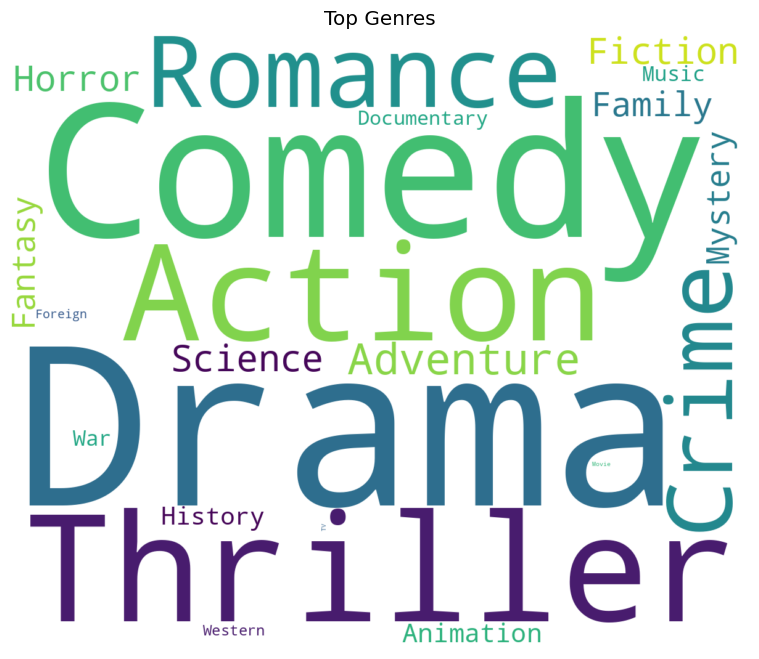

In [ ]:
list_of_genres = [' '.join([genre['name'] for genre in genres]) for genres in train_df['genres']]

# Concatenate the genre names
text = ' '.join(list_of_genres)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Genres')
plt.axis("off")
plt.show()



We can see that Comedy, Drama, Thriller, Romance are the popular genres in this dataset.

Creating separate columns for top 15 genres

In [ ]:
train_df['all_genres'] = train_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train_df['genre_' + g] = train_df['all_genres'].apply(lambda x: 1 if g in x else 0)

train_df = train_df.drop(['genres'], axis=1)


# same thing in test data
test_df['all_genres'] = test_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    test_df['genre_' + g] = test_df['all_genres'].apply(lambda x: 1 if g in x else 0)

test_df = test_df.drop(['genres'], axis=1)


**production_companies**

Let's look at another categorical feature which needs to
be converted into numerical feature i.e. production_companies. Let's calculate the number of production_companies in each movies, which will be a important factor in predicting box office revenue.

In [ ]:


train_df['num_production_companies'] = train_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)

test_df['num_production_companies'] = test_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
# Calculate the counts of films for each number of genres
prod_comp_counts = train_df['num_production_companies'].value_counts()

print(prod_comp_counts)

1     613
2     580
3     465
4     254
5     134
0     124
6      97
7      53
8      37
9      25
11      5
10      5
12      2
15      2
13      1
17      1
16      1
14      1
Name: num_production_companies, dtype: int64


We can see that, most of films have 1 to 2 production companies, and then 3 to 4. But there are few films too with more than 10 production companies.

In [ ]:
list_of_companies = list(train_df['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_companies)

[['United Artists', 'Monterey Productions', 'Charles K. Feldman Group'], [], [], ['Film 4', 'Film Four International', 'Beambright'], ['Universal Pictures'], ['Twentieth Century Fox Film Corporation'], ['Razor Film Produktion GmbH', 'Highlook Communications Group', 'Rotana Film Production', 'Dubai Entertainment and Media Organization'], ['Universal Pictures', 'StudioCanal'], ['Columbia Pictures', 'Innovisions'], ['PolyGram Filmed Entertainment', 'Working Title Films'], ['Warner Bros.', 'Touchstone Pictures', 'Syncopy'], ['Aurora Productions LLC', 'Kodiak Films'], ['CJ Capital Investment', 'Korea Capital Investment', 'Moho Films', 'TSJ Entertainment', 'Samsung Venture Capital', 'Ilshin Capital Investments', 'Centurion Investment'], ['PolyGram Filmed Entertainment'], ['Fox Searchlight Pictures', 'Kintop Pictures', 'Filmförderung Hamburg', 'UK Film Council'], ['Saga Film', 'Mobra Films', 'Mindshare Media', 'Centrul National al Cinematografiei (CNC)', 'McCann-Erickson', 'Televiziunea Roman

Calculating the binary columns for top 30 production_companies

In [ ]:
train_df['num_companies'] = train_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_production_companies'] = train_df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train_df['production_company_' + g] = train_df['all_production_companies'].apply(lambda x: 1 if g in x else 0)

test_df['num_companies'] = test_df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_production_companies'] = test_df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test_df['production_company_' + g] = test_df['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train_df = train_df.drop(['production_companies', 'all_production_companies'], axis=1)
test_df = test_df.drop(['production_companies', 'all_production_companies'], axis=1)

production_countries

In [ ]:
for i, e in enumerate(train_df['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'RU', 'name': 'Russia'}]
3 [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
4 [{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [ ]:
print('Number of production countries in films')
train_df['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    1762
2     428
3      97
4      50
0      43
5      18
6       1
8       1
Name: production_countries, dtype: int64

Nearly 75% of movies are produced by a single country.

In [ ]:
# List of countries with the ocunts of films produced
list_of_countries = list(train_df['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 1824),
 ('United Kingdom', 304),
 ('France', 187),
 ('Germany', 140),
 ('Canada', 101),
 ('India', 64),
 ('Australia', 55),
 ('Japan', 53),
 ('Italy', 52),
 ('Russia', 50),
 ('Spain', 43),
 ('China', 32),
 ('Hong Kong', 30),
 ('Belgium', 19),
 ('Ireland', 18),
 ('South Korea', 17),
 ('Mexico', 17),
 ('Sweden', 17),
 ('Netherlands', 11),
 ('New Zealand', 11),
 ('Denmark', 10),
 ('Brazil', 10),
 ('South Africa', 10),
 ('Czech Republic', 10),
 ('Romania', 8)]

Again, creating the numerical features which gives number of countris, and all countries related to a movie.

In [ ]:

train_df['num_countries'] = train_df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_countries'] = train_df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train_df['production_country_' + g] = train_df['all_countries'].apply(lambda x: 1 if g in x else 0)



test_df['num_countries'] = test_df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_countries'] = test_df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

for g in top_countries:
    test_df['production_country_' + g] = test_df['all_countries'].apply(lambda x: 1 if g in x else 0)

train_df = train_df.drop(['production_countries', 'all_countries'], axis=1)
test_df = test_df.drop(['production_countries', 'all_countries'], axis=1)

spoken_language

In [ ]:
train_df['spoken_languages'][:5]

0    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'ru', 'name': 'Pусский'}]
3             [{'iso_639_1': 'en', 'name': 'English'}]
4    [{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...
Name: spoken_languages, dtype: object

In [ ]:
train_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    1685
2     448
3     165
4      56
5      18
0      14
6       6
7       5
8       2
9       1
Name: spoken_languages, dtype: int64

In [ ]:
list_of_languages = list(train_df['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2089),
 ('Français', 244),
 ('Español', 193),
 ('Deutsch', 134),
 ('Pусский', 123),
 ('Italiano', 99),
 ('日本語', 73),
 ('普通话', 54),
 ('हिन्दी', 40),
 ('', 38),
 ('Português', 35),
 ('한국어/조선말', 30),
 ('العربية', 29),
 ('广州话 / 廣州話', 27),
 ('Magyar', 23)]

In [ ]:
#train_df['spoken_languages'] = train_df['spoken_languages'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x).any() else [])

train_df['num_languages'] = train_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_languages'] = train_df['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train_df['language_' + g] = train_df['all_languages'].apply(lambda x: 1 if g in x else 0)

test_df['num_languages'] = test_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_languages'] = test_df['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test_df['language_' + g] = test_df['all_languages'].apply(lambda x: 1 if g in x else 0)



In [ ]:
train_df = train_df.drop(['spoken_languages', 'all_languages'], axis=1)
test_df = test_df.drop(['spoken_languages', 'all_languages'], axis=1)

Keywords

In [ ]:
for i, e in enumerate(train_df['Keywords'][:5]):
    print(i, e)

0 [{'id': 1556, 'name': 'texas'}, {'id': 3851, 'name': 'dangerous'}, {'id': 7658, 'name': 'kansas'}, {'id': 9656, 'name': 'cattle drive'}, {'id': 9748, 'name': 'revenge'}, {'id': 15225, 'name': 'cattle'}, {'id': 185927, 'name': 'adopted child'}, {'id': 208505, 'name': 'cattle empire'}]
1 [{'id': 187056, 'name': 'woman director'}]
2 nan
3 [{'id': 255, 'name': 'male nudity'}, {'id': 293, 'name': 'female nudity'}, {'id': 1155, 'name': 'brother sister relationship'}, {'id': 1489, 'name': 'river thames'}, {'id': 2564, 'name': 'wheelchair'}, {'id': 3691, 'name': 'forbidden love'}, {'id': 6038, 'name': 'marriage'}, {'id': 9772, 'name': 'pubic hair'}, {'id': 10181, 'name': 'based on play or musical'}, {'id': 10329, 'name': 'wealth'}, {'id': 33841, 'name': 'incest'}, {'id': 181531, 'name': 'brother sister incest'}, {'id': 211279, 'name': 'erotica'}]
4 [{'id': 378, 'name': 'prison'}, {'id': 2636, 'name': 'blues'}, {'id': 6231, 'name': 'half-brother'}, {'id': 6783, 'name': 'orphanage'}, {'id': 33

In [ ]:
print('Number of Keywords in films')
train_df['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5     231
0     226
4     199
3     180
6     168
7     163
1     155
2     151
8     133
11    110
Name: Keywords, dtype: int64

Word Cloud for visualizing most common keywords in movies


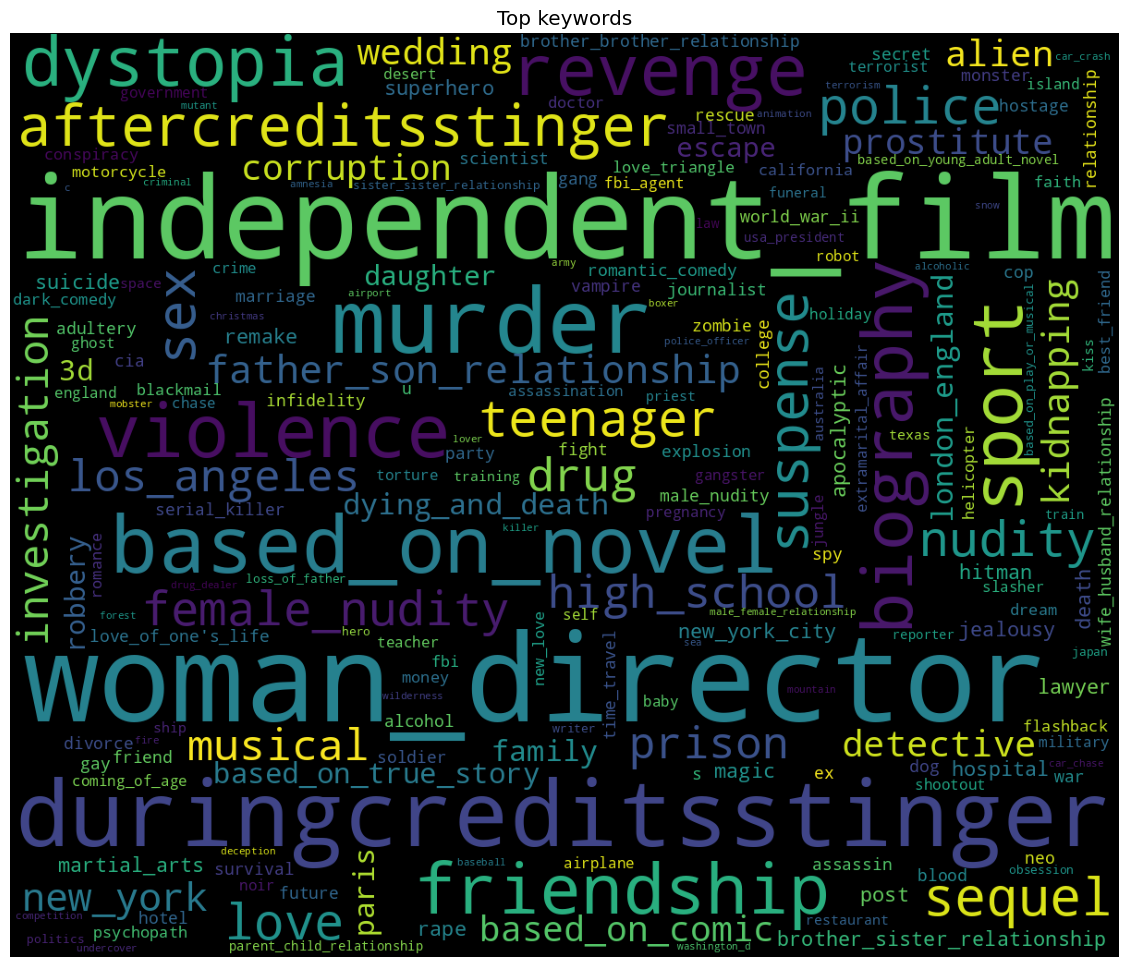

In [ ]:
list_of_keywords = list(train_df['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

Extracting Numerical and Binary features from 'keywords' feature

In [ ]:
train_df['num_Keywords'] = train_df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train_df['all_Keywords'] = train_df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# top (common) keywords
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train_df['keyword_' + g] = train_df['all_Keywords'].apply(lambda x: 1 if g in x else 0)




DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [ ]:
test_df['num_Keywords'] = test_df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test_df['all_Keywords'] = test_df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test_df['keyword_' + g] = test_df['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train_df = train_df.drop(['Keywords', 'all_Keywords'], axis=1)
test_df = test_df.drop(['Keywords', 'all_Keywords'], axis=1)

cast

In [ ]:
for i, e in enumerate(train_df['cast'][:1]):
    print(i, e)

0 [{'cast_id': 10, 'character': 'Thomas Dunson', 'credit_id': '52fe4384c3a36847f805a495', 'gender': 2, 'id': 4165, 'name': 'John Wayne', 'order': 0, 'profile_path': '/iw9gHSQj1l3TQeiJb5tNK2N8k2w.jpg'}, {'cast_id': 11, 'character': "Matthew 'Matt' Garth", 'credit_id': '52fe4384c3a36847f805a499', 'gender': 2, 'id': 12151, 'name': 'Montgomery Clift', 'order': 1, 'profile_path': '/AlfXmaeZaoCffoVziEmuc4UIA5U.jpg'}, {'cast_id': 12, 'character': 'Tess Millay', 'credit_id': '52fe4384c3a36847f805a49d', 'gender': 1, 'id': 30296, 'name': 'Joanne Dru', 'order': 2, 'profile_path': '/f2Zi7xK4mOdQiTkSzIRaAAY7DhS.jpg'}, {'cast_id': 13, 'character': "'Groot' Nadine", 'credit_id': '52fe4384c3a36847f805a4a1', 'gender': 2, 'id': 4302, 'name': 'Walter Brennan', 'order': 3, 'profile_path': '/wPp0mmWWVMzOD3ipne6MrgDr0Tm.jpg'}, {'cast_id': 14, 'character': 'Fen', 'credit_id': '52fe4384c3a36847f805a4a5', 'gender': 0, 'id': 3336, 'name': 'Coleen Gray', 'order': 4, 'profile_path': '/oQhVm1YUKaAAAT9TcBJ8RtrUuZS.

Since the quality of the film depends upon the number of casted actors too, let's have a look.

In [ ]:
print('Number of casted persons in films')
train_df['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(20)

Number of casted persons in films


15    168
16    142
10    110
13    103
9      97
18     96
17     96
11     94
12     93
14     91
19     81
8      78
7      76
20     69
22     65
6      59
21     58
23     57
24     46
4      46
Name: cast, dtype: int64

In [ ]:
# List of casts and popular casts

list_of_cast_names = list(train_df['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 26),
 ('Robert De Niro', 25),
 ('Morgan Freeman', 23),
 ('Forest Whitaker', 21),
 ('Sigourney Weaver', 20),
 ('Bruce McGill', 20),
 ('Keith David', 20),
 ('Owen Wilson', 19),
 ('Sylvester Stallone', 19),
 ('Liam Neeson', 19),
 ('J.K. Simmons', 19),
 ('John Goodman', 18),
 ('William H. Macy', 18),
 ('Willem Dafoe', 18),
 ('Kevin Bacon', 18)]

In [ ]:
# list_of_cast_names_url = list(train_df['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
# d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
# fig = plt.figure(figsize=(20, 12))
# for i, p in enumerate([j[0] for j in d]):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
#     plt.imshow(im)
#     ax.set_title(f'{p[0]}')

Extracting numerical or encoded features liek number of casts, gender of casts, and cast characters from cast feature.

In [ ]:
# List of cast genders, encoded by 0 for unspecified, 1 for female, and 2 for male.
list_of_cast_genders = list(train_df['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 22307), (0, 16402), (1, 10786)]

In [ ]:
# cast and their characters

list_of_cast_characters = list(train_df['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 661),
 ('Himself', 530),
 ('Dancer', 135),
 ('Herself', 133),
 ('Additional Voices (voice)', 75),
 ('Reporter', 59),
 ('Doctor', 57),
 ('Waitress', 57),
 ('Nurse', 55),
 ('Debutante', 54),
 ('Jack', 42),
 ('Bartender', 41),
 ('Paul', 39),
 ('Tony', 38),
 ('Nightclub Dancer', 38)]

In [ ]:
train_df['num_cast'] = train_df['cast'].apply(lambda x: len(x) if x != {} else 0)

top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]

for g in top_cast_names:
    train_df['cast_name_' + g] = train_df['cast'].apply(lambda x: 1 if g in str(x) else 0)
train_df['genders_0_cast'] = train_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_df['genders_1_cast'] = train_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_df['genders_2_cast'] = train_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train_df['cast_character_' + g] = train_df['cast'].apply(lambda x: 1 if g in str(x) else 0)

In [ ]:
test_df['num_cast'] = test_df['cast'].apply(lambda x: len(x) if x != {} else 0)

for g in top_cast_names:
    test_df['cast_name_' + g] = test_df['cast'].apply(lambda x: 1 if g in str(x) else 0)

test_df['genders_0_cast'] = test_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_df['genders_1_cast'] = test_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_df['genders_2_cast'] = test_df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

for g in top_cast_characters:
    test_df['cast_character_' + g] = test_df['cast'].apply(lambda x: 1 if g in str(x) else 0)

train_df = train_df.drop(['cast'], axis=1)
test_df = test_df.drop(['cast'], axis=1)

Cast Crews

In [ ]:

train_df['crew'] = train_df['crew'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
train_df['crew'][:10]

0    [{'credit_id': '52fe4384c3a36847f805a485', 'de...
1    [{'credit_id': '52fe45c2c3a36847f80d8e9d', 'de...
2    [{'credit_id': '52fe45e5c3a36847f80e08db', 'de...
3    [{'credit_id': '52fe4881c3a36847f816abb5', 'de...
4    [{'credit_id': '52fe445d9251416c750321a7', 'de...
5    [{'credit_id': '52fe44779251416c91011acb', 'de...
6    [{'credit_id': '52fe4b33c3a368484e17ceb7', 'de...
7    [{'credit_id': '52fe44fdc3a36847f80b6459', 'de...
8    [{'credit_id': '52fe4486c3a368484e027e2d', 'de...
9    [{'credit_id': '52fe4231c3a36847f800af4d', 'de...
Name: crew, dtype: object

The great crew is very important in creating the film. We have not only the names of the crew members, but also the genders, jobs and departments.

In [ ]:

print('Number of casted persons in films')
train_df['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


2     140
3     107
10    100
11     94
9      93
8      90
14     87
12     86
4      76
7      74
Name: crew, dtype: int64

In [ ]:
list_of_crew_names = list(train_df['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 41),
 ('Robert Rodriguez', 39),
 ('Luc Besson', 34),
 ('Deborah Aquila', 33),
 ('James Newton Howard', 31),
 ('Francine Maisler', 30),
 ('James Horner', 29),
 ('Jerry Goldsmith', 28),
 ('Tricia Wood', 28),
 ('Steven Spielberg', 27),
 ('Kerry Barden', 27),
 ('Alan Silvestri', 25),
 ('Mary Vernieu', 25),
 ('John Debney', 25),
 ('Janet Hirshenson', 24)]

In [ ]:
# List of Crew jobs

list_of_crew_jobs = list(train_df['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 4824),
 ('Executive Producer', 2710),
 ('Director', 2589),
 ('Screenplay', 2385),
 ('Editor', 2265),
 ('Casting', 1993),
 ('Director of Photography', 1812),
 ('Original Music Composer', 1582),
 ('Art Direction', 1449),
 ('Production Design', 1337),
 ('Costume Design', 1272),
 ('Writer', 1252),
 ('Set Decoration', 1075),
 ('Makeup Artist', 920),
 ('Sound Re-Recording Mixer', 789)]

In [ ]:
# list of Crew Genders
list_of_crew_genders = list(train_df['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 33628), (2, 19963), (1, 5114)]

In [ ]:
# list of Crew Departments

list_of_crew_departments = list(train_df['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)

Creating Numerical and Encoded Features from Crew feature

In [ ]:
train_df['num_crew'] = train_df['crew'].apply(lambda x: len(x) if x != {} else 0)

top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]

for g in top_crew_names:
    train_df['crew_name_' + g] = train_df['crew'].apply(lambda x: 1 if g in str(x) else 0)
train_df['genders_0_crew'] = train_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_df['genders_1_crew'] = train_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_df['genders_2_crew'] = train_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))


top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]

for j in top_crew_jobs:
    train_df['jobs_' + j] = train_df['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))

top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]

for j in top_crew_departments:
    train_df['departments_' + j] = train_df['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))

In [ ]:

# same process in test data
test_df['num_crew'] = test_df['crew'].apply(lambda x: len(x) if x != {} else 0)

for g in top_crew_names:
    test_df['crew_name_' + g] = test_df['crew'].apply(lambda x: 1 if g in str(x) else 0)

test_df['genders_0_crew'] = test_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_df['genders_1_crew'] = test_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_df['genders_2_crew'] = test_df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

for j in top_crew_jobs:
    test_df['jobs_' + j] = test_df['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))

for j in top_crew_departments:
    test_df['departments_' + j] = test_df['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))

train_df = train_df.drop(['crew'], axis=1)
test_df = test_df.drop(['crew'], axis=1)

# Data Exploration

In [ ]:
train_df.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
0,0,3000000,NaN,tt0040724,en,Red River,Dunson is driving his cattle to Red River when...,6.090180,/9TwFtppqU0zUvtNTIDxkV7zQebC.jpg,8/26/48,...,0,0,2,0,1,2,1,0,0,0
1,1,0,NaN,tt0099028,en,American Dream,Chronicles the six-month strike at Hormel in A...,0.075885,/oi2vKZROaDoJpt1vvKXeQOTKlNK.jpg,9/28/90,...,0,0,0,0,0,4,0,0,0,0
2,2,5000000,NaN,tt0325005,ru,Антикиллер,"Former criminal investigator, Major Korenev, n...",0.191539,/pkdnzpmacniXKJnEmlD7q5KCFrw.jpg,8/1/02,...,0,0,2,0,0,1,0,0,0,0
3,3,0,NaN,tt0101595,en,Close My Eyes,"After some years of tension, Richard begins a ...",1.404434,/r6llY1uyhQOXLh8lFuohoed315.jpg,11/22/91,...,1,0,1,1,1,1,1,0,0,0
4,4,28000000,NaN,tt0118747,en,Blues Brothers 2000,"Elwood, the now lone ""Blues Brother"" finally r...",13.162168,/87FRtfvpH6nGhGRIDymcNGn6duK.jpg,2/5/98,...,0,0,2,0,1,1,1,0,0,0


In [ ]:
test_df.drop('belongs_to_collection', axis = 1)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


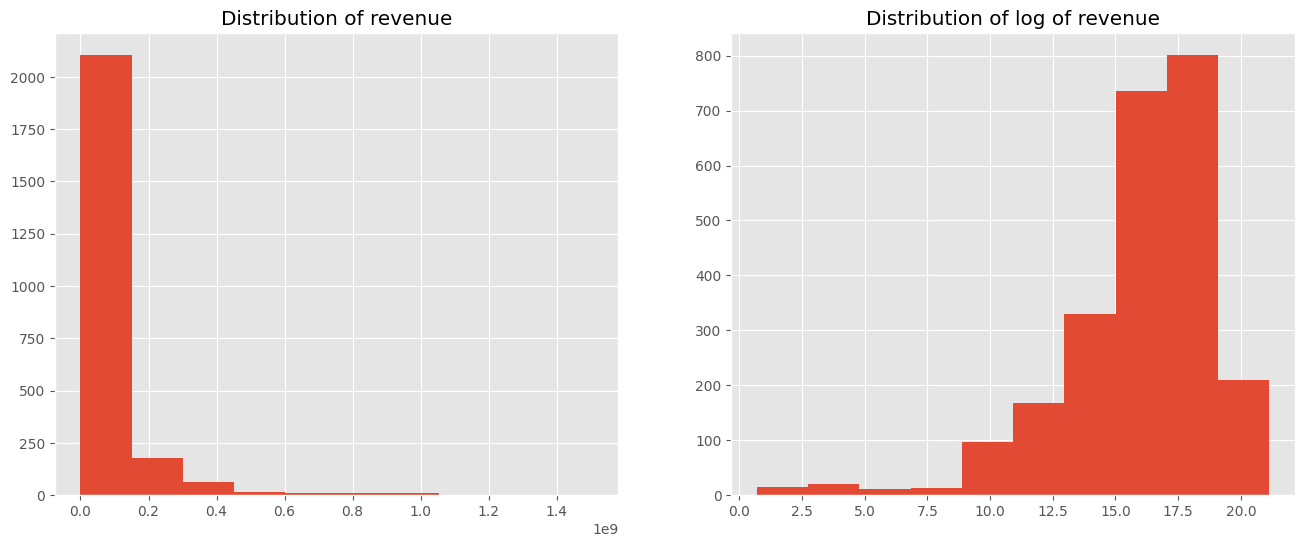

In [ ]:
# Distribution of Revenue

fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['revenue']));
plt.title('Distribution of log of revenue');

The revenue distribution has a high skewness! It is better to use np.log1p of revenue to have better distribution.

In [ ]:
train_df['log_revenue'] = np.log1p(train_df['revenue'])

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


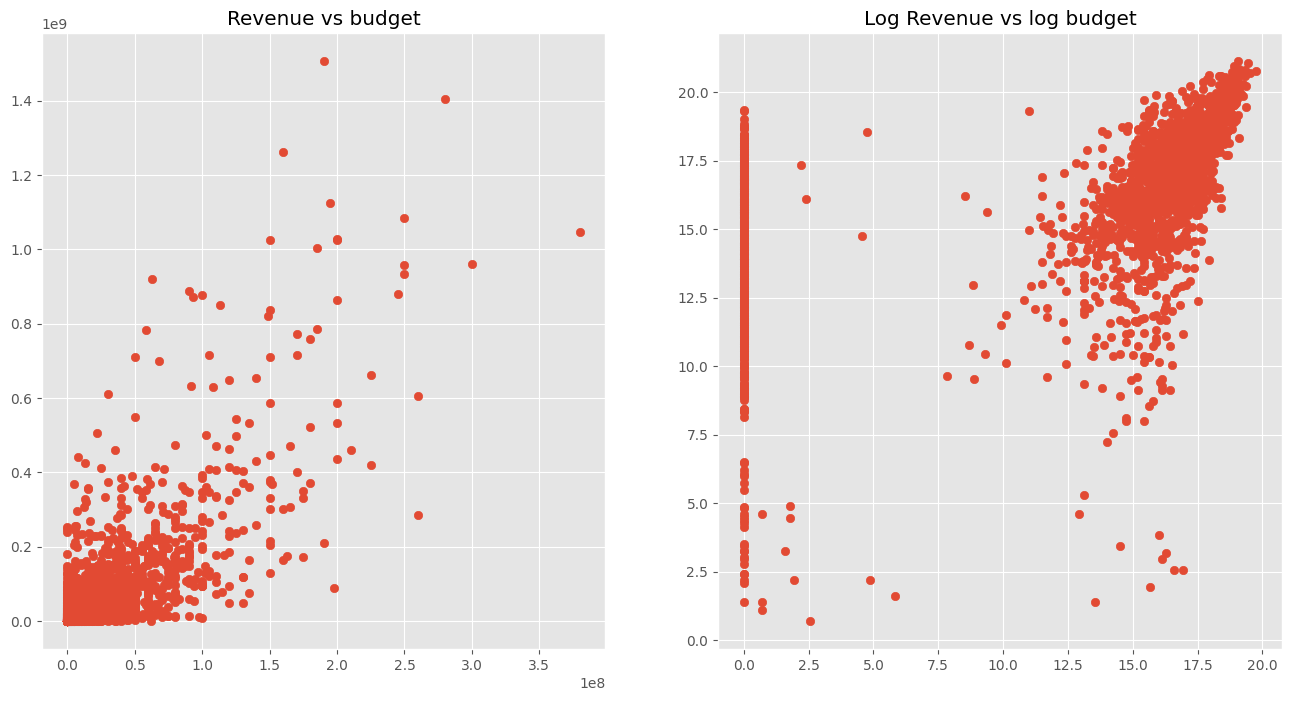

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_df['budget'], train_df['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train_df['budget']), train_df['log_revenue'])
plt.title('Log Revenue vs log budget');

We can see that budget and revenue are somewhat correlated. Logarithm transformation makes budget distribution more managable.

In [ ]:
train_df['log_budget'] = np.log1p(train_df['budget'])
test_df['log_budget'] = np.log1p(test_df['budget'])

In [ ]:
train_df['homepage'].value_counts().head()

http://www.transformersmovie.com/         4
http://www.themoviefargo.com/             1
http://www.thedayaftertomorrow.com/       1
http://copoutmovie.warnerbros.com/dvd/    1
http://movies.disney.com/the-pacifier     1
Name: homepage, dtype: int64

Most of homepages are unique, so this feature may be useless.

Revenue of Film with and without Homepage

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


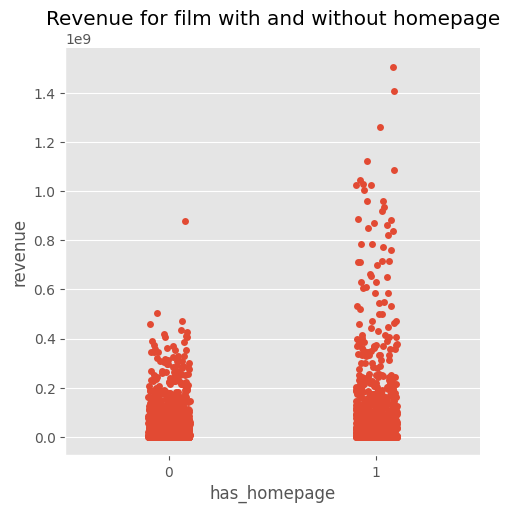

In [ ]:
train_df['has_homepage'] = 0
train_df.loc[train_df['homepage'].isnull() == False, 'has_homepage'] = 1
test_df['has_homepage'] = 0
test_df.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

sns.catplot(x='has_homepage', y='revenue', data=train_df);
plt.title('Revenue for film with and without homepage');

Films with homepage tend to generate more revenue!

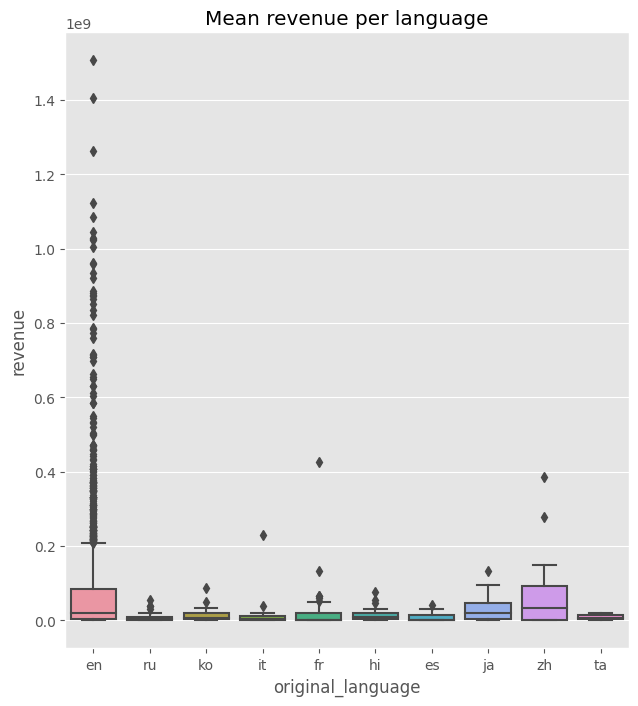

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train_df.loc[train_df['original_language'].isin(train_df['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
# plt.subplot(1, 2, 2)
# sns.boxplot(x='original_language', y='log_revenue', data=train_df.loc[train_df['original_language'].isin(train_df['original_language'].value_counts().head(10).index)]);
# plt.title('Mean log revenue per language');

There are much more english films and they have a higher range of values. Films with the highest revenue are usually in English, but there are also high revenue films in other languages

**original_title**

It can be interesting to see which words are common in titles.

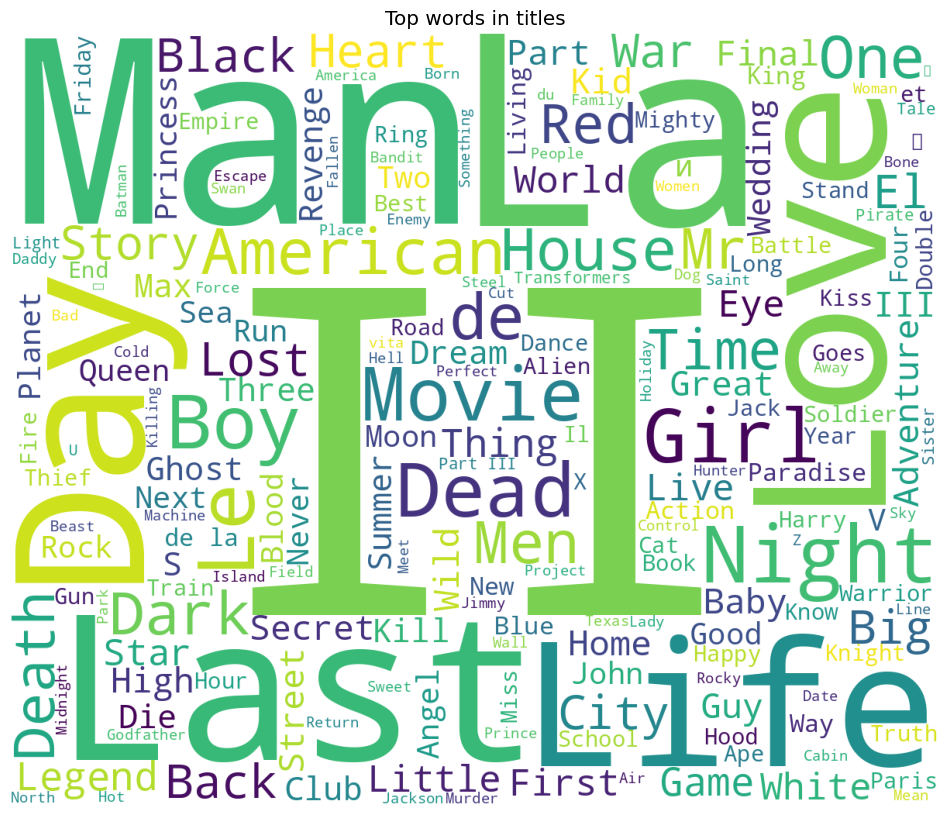

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_df['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

Overview


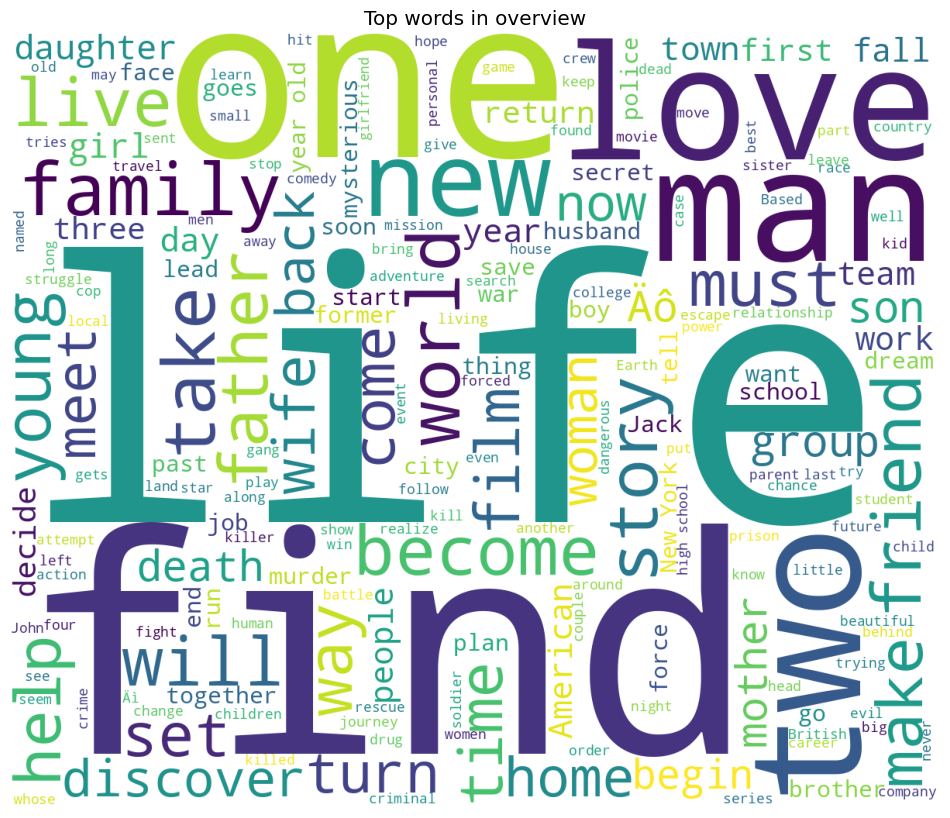

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_df['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

Let's see which words have high impact on the revenue. I'll build a simple model and use ELI5 for this

In [ ]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train_df['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train_df['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
print('Target value:', train_df['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train_df['overview'].values[1000], vec=vectorizer)

Target value: 14.98447785665394


It shows that some words can be used to predict revenue, but we will need more that overview text to build a good model.

Correlation of Popularity and Revenue


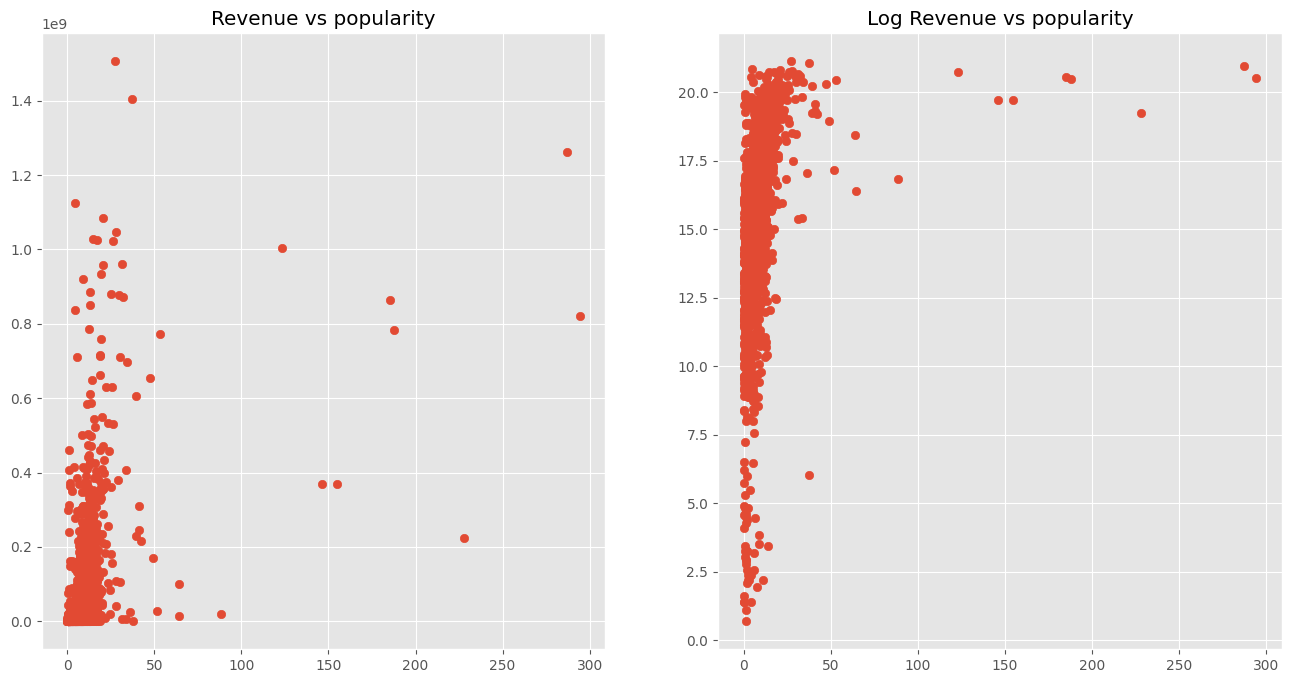

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_df['popularity'], train_df['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train_df['popularity'], train_df['log_revenue'])
plt.title('Log Revenue vs popularity');

It seems that popularity has low correlation with the Box Office Revenue.

release_date

In [ ]:
# Correlation of Release day of week and Revenue


Correlation of Length of Film and Revenue

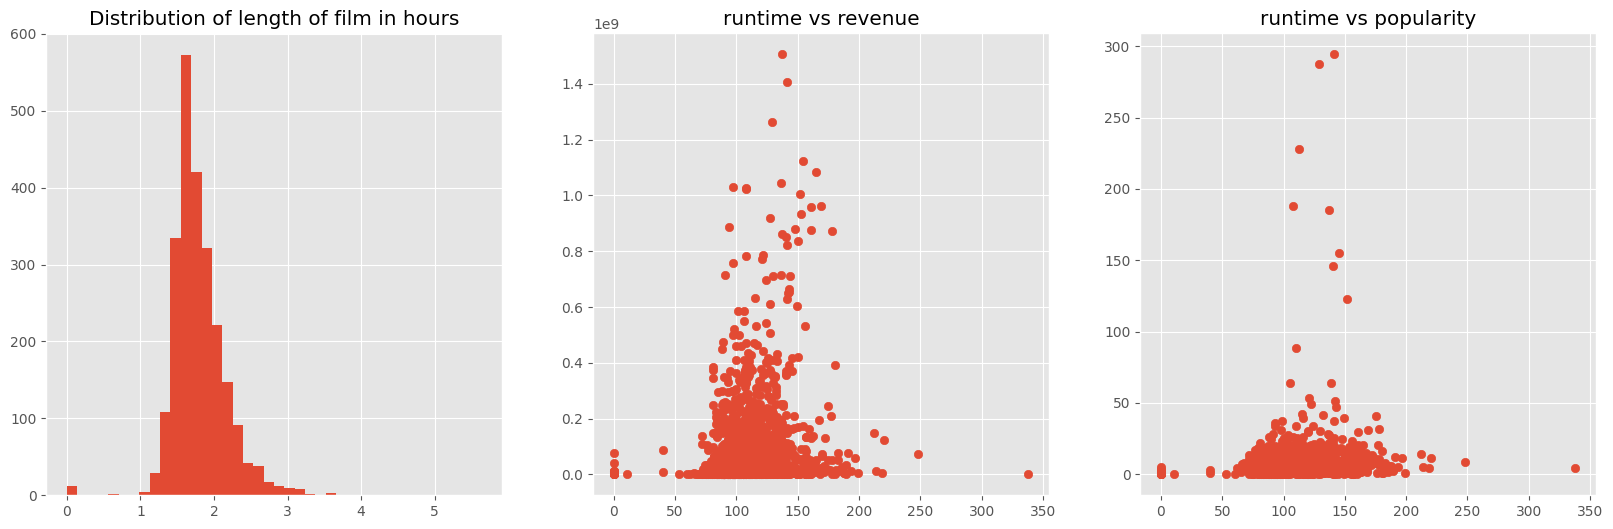

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train_df['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train_df['runtime'].fillna(0), train_df['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train_df['runtime'].fillna(0), train_df['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range.

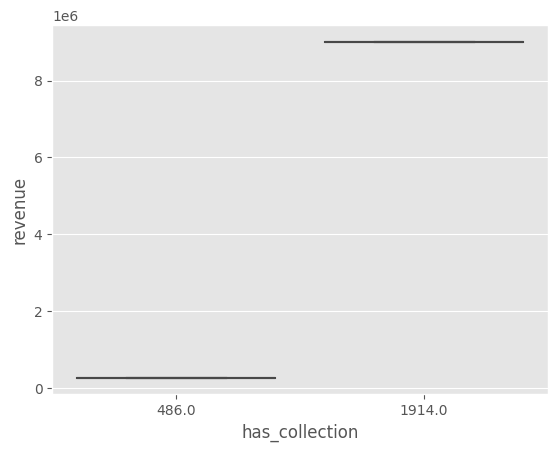

In [ ]:
# Collection and Revenue

sns.boxplot(x='has_collection', y='revenue', data=train_df);

Films which are part of a collection usually have higher revenues

Genre and Revenue

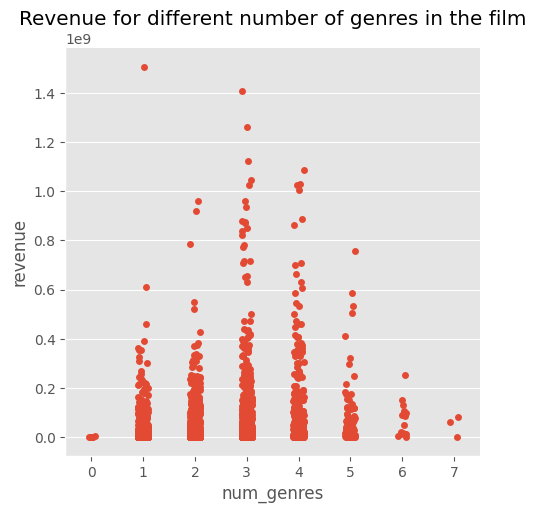

In [ ]:
sns.catplot(x='num_genres', y='revenue', data=train_df);
plt.title('Revenue for different number of genres in the film');

Films with 3 to 4 genre have high revenue.

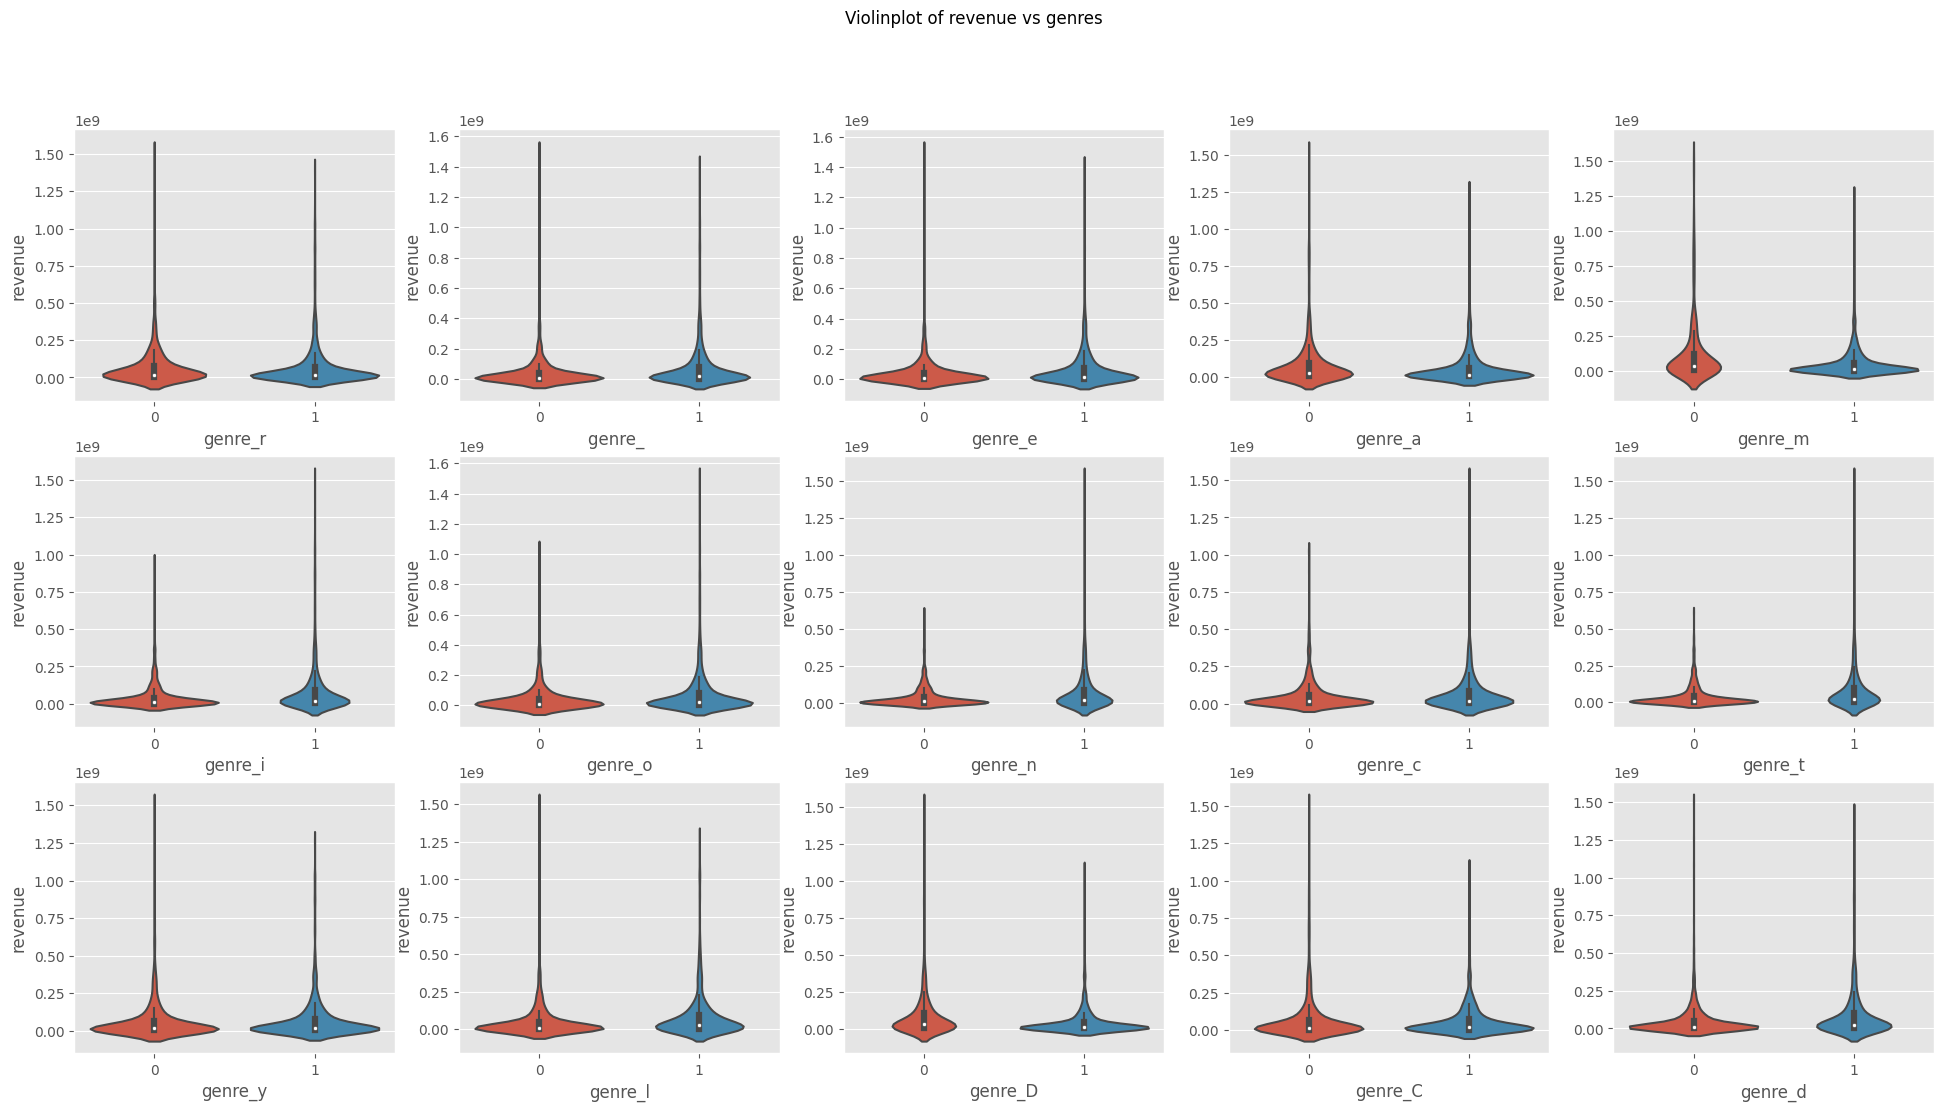

In [ ]:
# violinplot of revenue vs genre

f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train_df.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train_df, ax=axes[i // 5][i % 5]);

cast

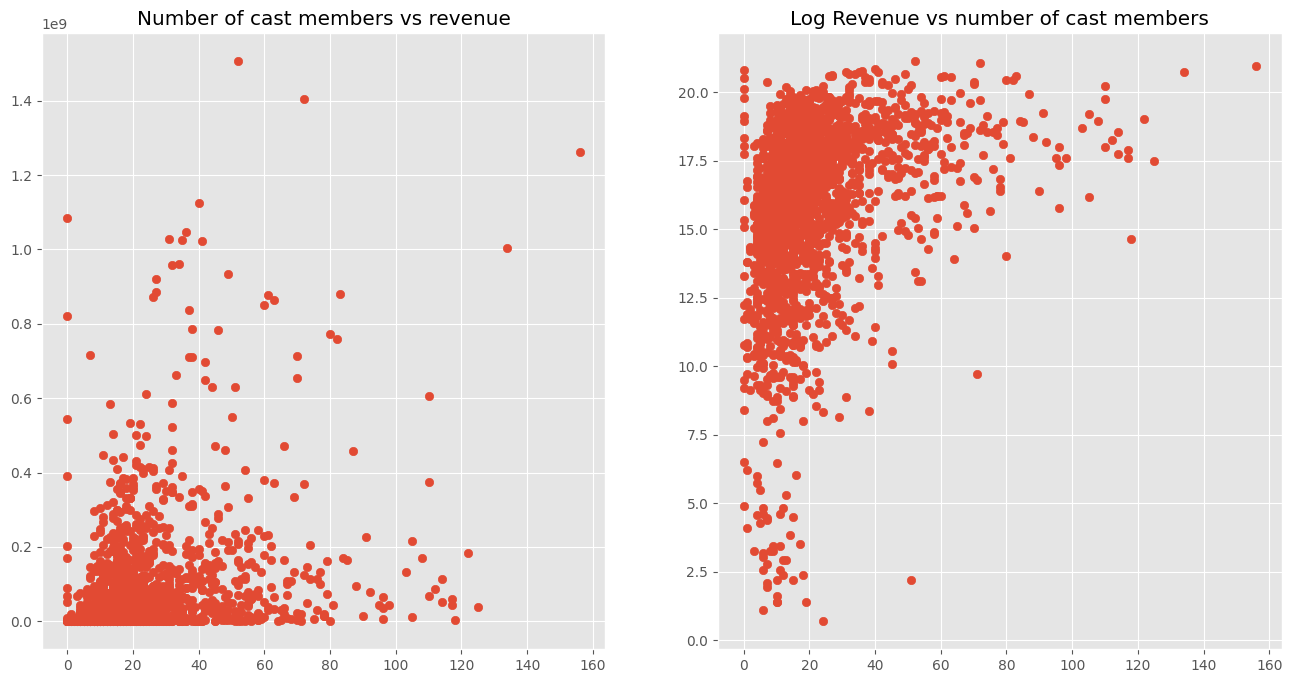

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_df['num_cast'], train_df['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train_df['num_cast'], train_df['log_revenue'])
plt.title('Log Revenue vs number of cast members');

keywords

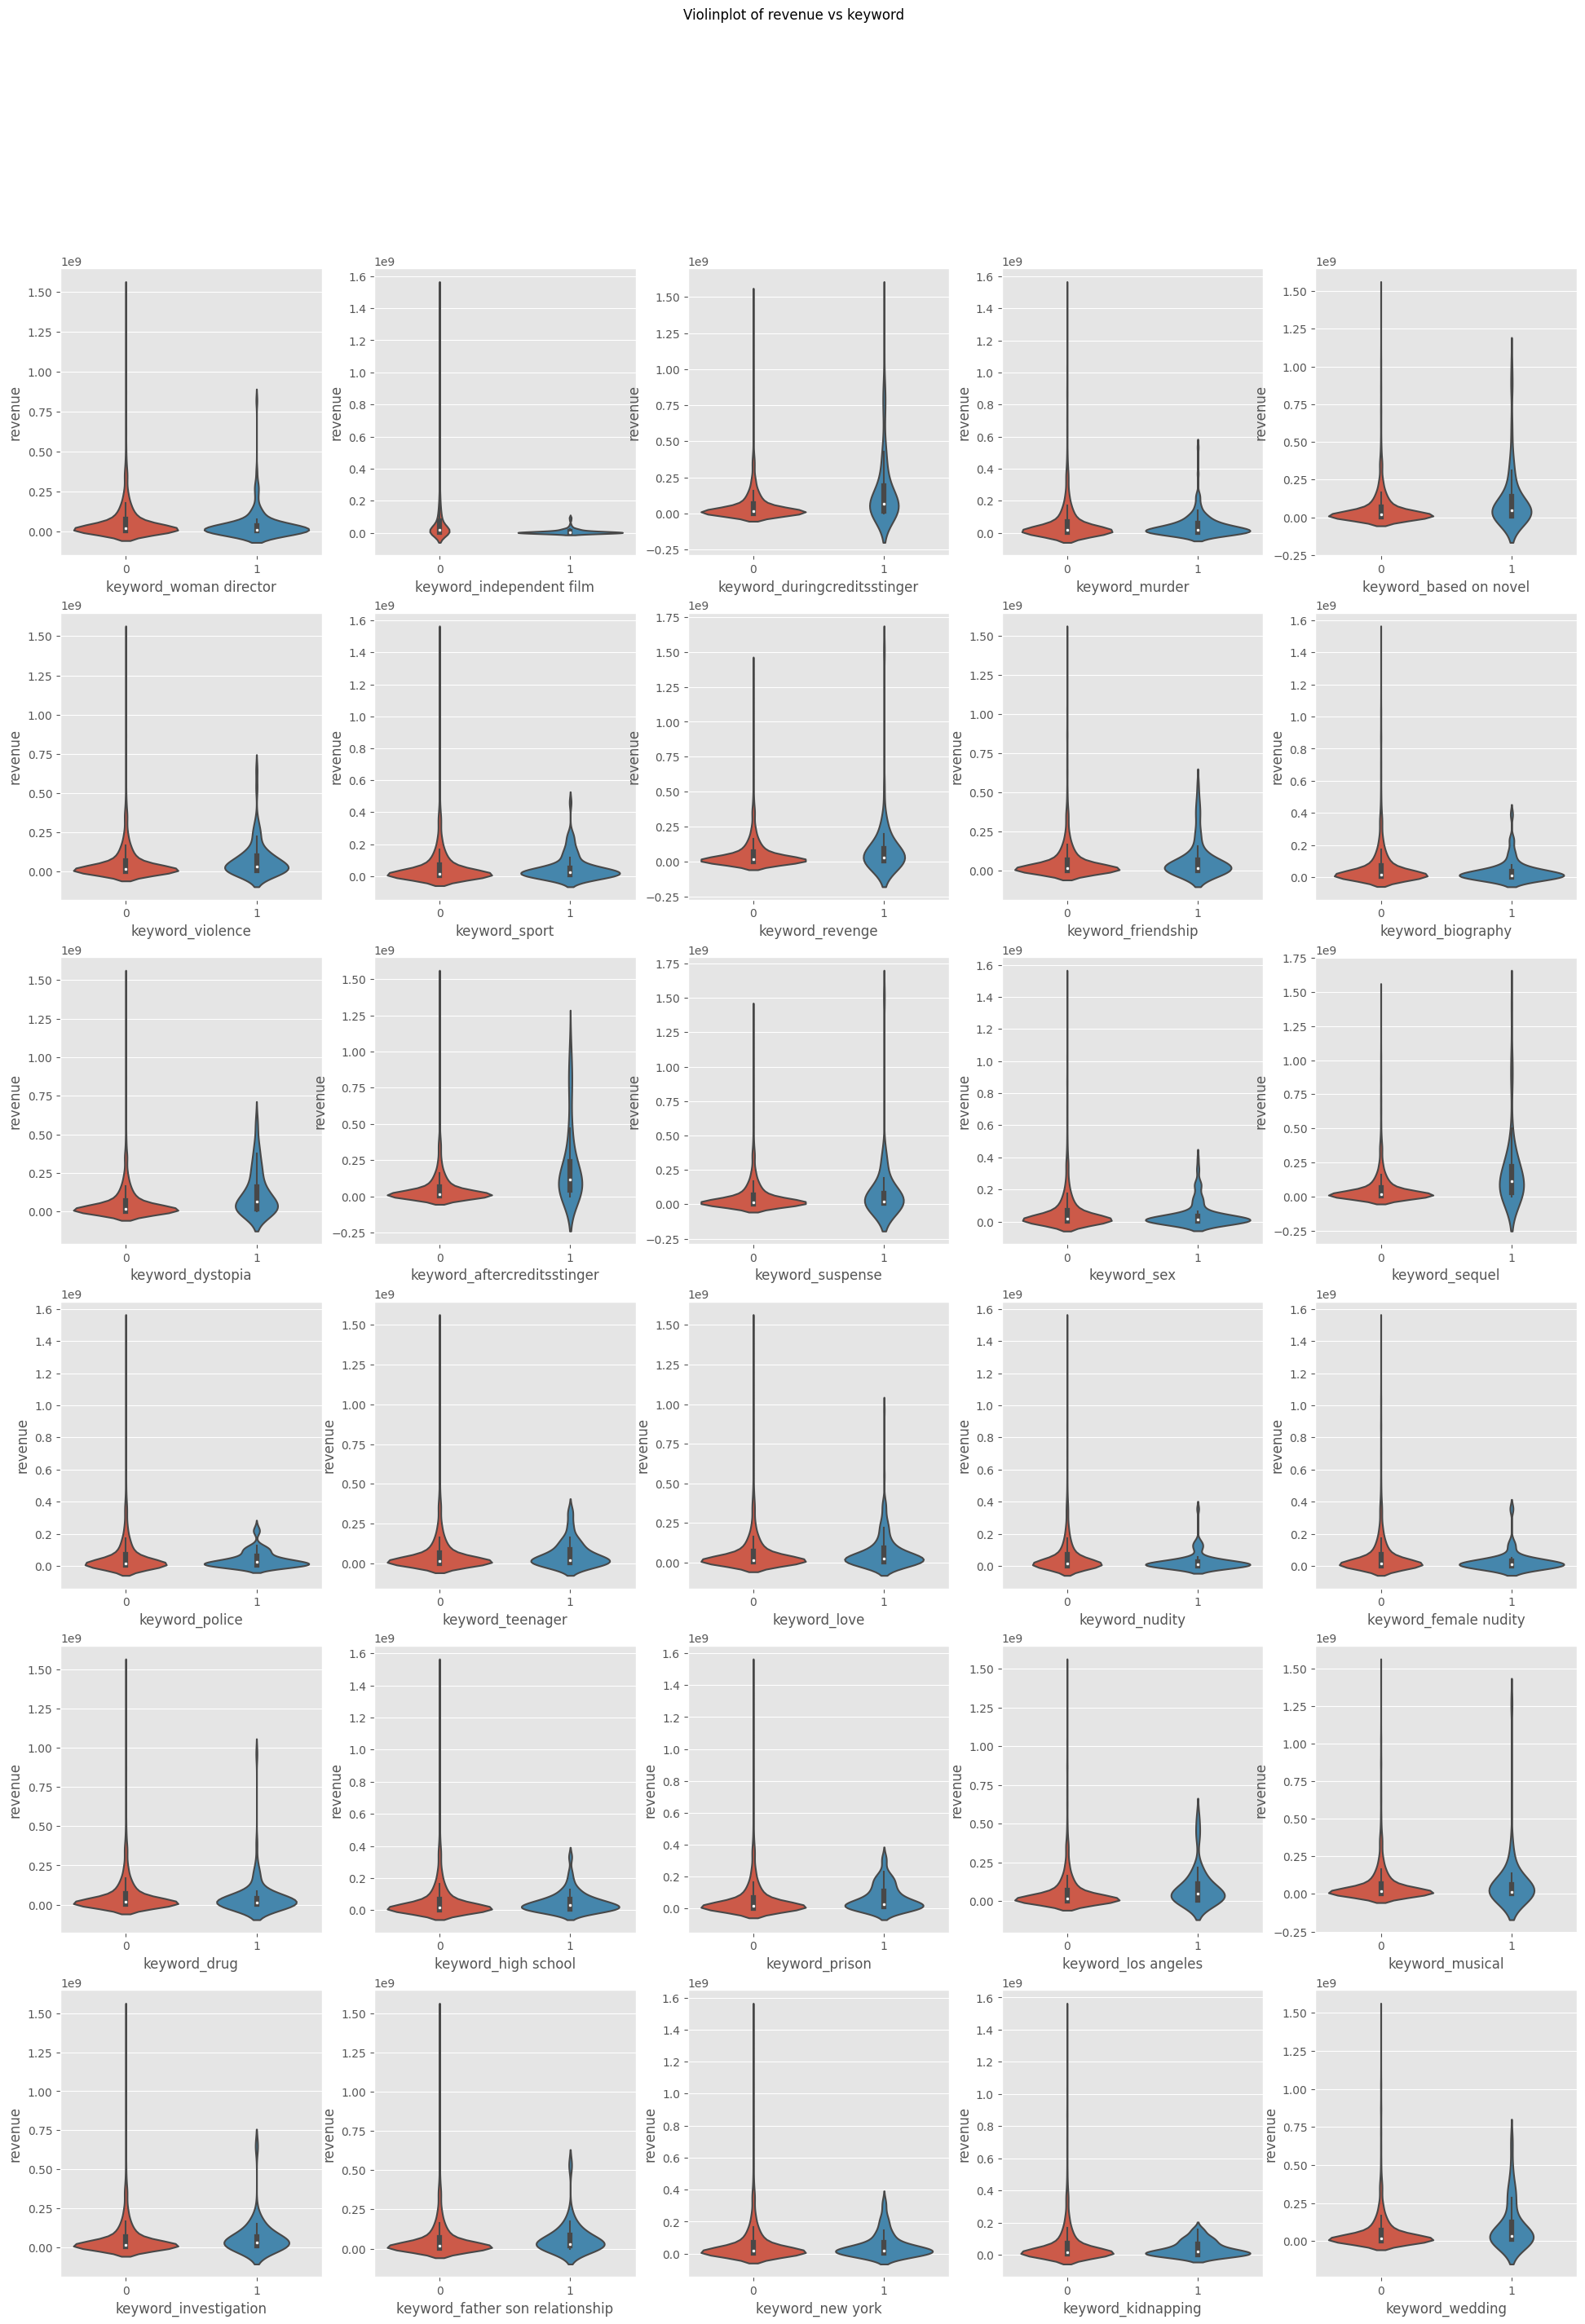

In [ ]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train_df.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train_df, ax=axes[i // 5][i % 5]);

number of crew

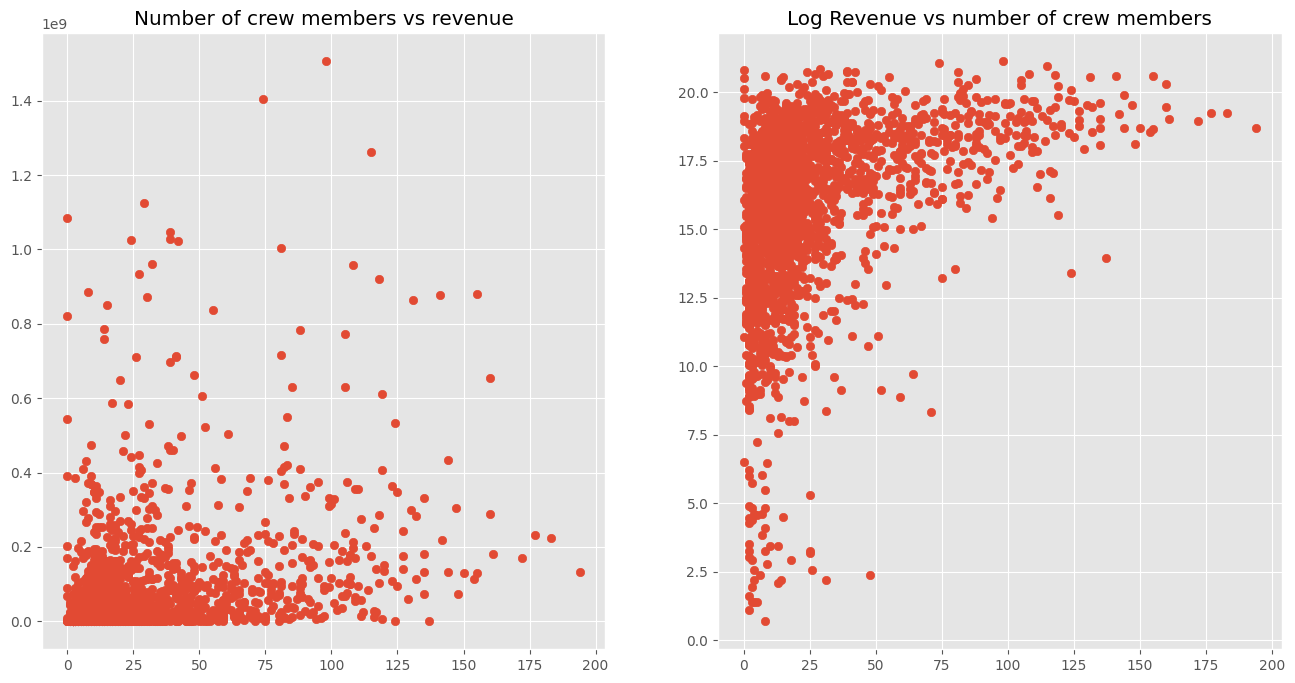

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_df['num_crew'], train_df['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train_df['num_crew'], train_df['log_revenue'])
plt.title('Log Revenue vs number of crew members');

# Modelling and Feature **Generation**

In [ ]:
train = train_df.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test_df.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [ ]:
# Checking if there's any features missing between train and test set.

missing_features = set(train.columns) - set(test.columns)
if missing_features:
    print("The following features are present in the train set but not in the test set:")
    print(missing_features)
else:
    print("All features in the test set are present in the train set.")

The following features are present in the train set but not in the test set:
{'revenue'}


That's obvious, revenue column will not be in test set, it is the target we have to predict/calculate. So, we're good to go.

In [ ]:
# for col in train.columns:
#     if train[col].nunique() == 1:
#         print(col)
#         train = train.drop([col], axis=1)
#         test = test.drop([col], axis=1)

In [ ]:
print(list(train.columns))

['id', 'budget', 'original_language', 'popularity', 'runtime', 'revenue', 'has_collection', 'num_genres', 'all_genres', 'genre_r', 'genre_ ', 'genre_e', 'genre_a', 'genre_m', 'genre_i', 'genre_o', 'genre_n', 'genre_c', 'genre_t', 'genre_y', 'genre_l', 'genre_D', 'genre_C', 'genre_d', 'num_production_companies', 'num_companies', 'production_company_Warner Bros.', 'production_company_Universal Pictures', 'production_company_Paramount Pictures', 'production_company_Twentieth Century Fox Film Corporation', 'production_company_Columbia Pictures', 'production_company_Metro-Goldwyn-Mayer (MGM)', 'production_company_Touchstone Pictures', 'production_company_New Line Cinema', 'production_company_Walt Disney Pictures', 'production_company_Columbia Pictures Corporation', 'production_company_TriStar Pictures', 'production_company_Canal+', 'production_company_Relativity Media', 'production_company_United Artists', 'production_company_Village Roadshow Pictures', 'production_company_Miramax Films', '

In [ ]:
for col in ['original_language', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [ ]:
#train_texts = train[['title', 'tagline', 'overview', 'original_title']]
# test_texts = test[['title', 'tagline', 'overview', 'original_title']]


In [ ]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [ ]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])               # applied to the target variable in regression tasks to improve the model's performance when the target values have a wide range
X_test = test.drop(['id'], axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [ ]:
X_train.head()

,budget,original_language,popularity,runtime,has_collection,num_genres,all_genres,genre_r,genre_,genre_e,...,has_homepage,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,num_languages
1979,125000,7,10.850569,90.0,NaN,2,321,1,1,1,...,1,20,30,59,93,213,322,20,30,1
852,65000000,7,9.782014,100.0,NaN,3,13,1,1,1,...,0,11,18,26,42,291,451,11,18,2
71,140000000,7,47.326665,143.0,NaN,3,65,1,1,1,...,1,54,85,37,62,293,435,54,85,1
1576,0,11,0.352330,91.0,NaN,2,471,1,1,0,...,0,21,31,0,4,55,86,10,14,1
499,30000000,7,21.946943,81.0,NaN,3,281,0,1,1,...,1,9,16,0,4,303,454,9,16,1


In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-156-2582d182fbe3>", line 15, in <cell line: 15>
    model1.fit(X_train, y_train,
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 2605, in __init__
    train_set.construct()
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 1815, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib

Comparing these RMSE values, the training RMSE is consistently lower than the validation RMSE, which suggests that the model is performing well on the training data. However, the validation RMSE values are higher, indicating that the model may be slightly overfitting the training data and not generalizing as well to the validation data.

In [ ]:
# Feature weight of the model
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.3864,budget
0.1589,popularity
0.0588,log_budget
0.0373,runtime
0.0359,genders_2_crew
0.0299,all_genres
0.0165,num_cast
0.0163,genders_2_cast
0.0147,genders_1_cast
0.0133,num_Keywords


By looking at the, we can gather key insights like

Budget (budget) is the most important feature with a weight of 0.3389. This indicates that the budget of a movie has a significant impact on its box office revenue.

Popularity (popularity) is the second most important feature with a weight of 0.1559. This suggests that the popularity of a movie, possibly measured by factors like online search trends, social media buzz, or user ratings, also plays a substantial role in predicting its box office success.

Other features such as log_budget, runtime, genders_2_crew, all_genres, and genders_2_cast also have notable weights, though relatively smaller than the budget and popularity.

In [ ]:
# Fine tuning the model

Using Cross-validation to see a more reliable estimate of model performance compared to a single train-test split.

In [ ]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])                                 # prediction on test set
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())

        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        # Light GBM
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        #xgboost
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)

            y_pred = model.predict(X_test)

        #catboost
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)

        prediction += y_pred

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold             # averaged prediction


    # print the mean and standard deviation of the evaluation scores across all folds
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');

            return oof, prediction, feature_importance
        return oof, prediction

    else:
        return oof, prediction

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [ ]:
X.shape[1], X_test.shape[1]

(233, 232)

There is one less feature in training set.

Debugging it to see the missing feature.

# Additional Feature Generation

In [ ]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']

    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']

    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')

    return df